In [ ]:
%load_ext autoreload
from coffea import util, processor
from msdprocessor5 import msdProcessor

from coffea.nanoevents import NanoEventsFactory, PFNanoAODSchema
import json
import distributed
import dask
import awkward as ak
import hist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.animation import FuncAnimation, PillowWriter
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from hist import Hist
import dask_awkward
import os
import math




directory_path = "/uscms/home/jennetd/nobackup/hbb-prod-modes/run3-triggers/data-mc/"

#Generating the fileset

#If you want to process less files, specify that here:

fileset = []
for filename in os.listdir(directory_path):
    if filename.endswith("ZH.root"):
        fileset.append(os.path.join(directory_path, filename))

print("Fileset:", fileset)




#SET SOFTDROP PARAMETERS HERE

n_global = 300

beta_min_global = 0
beta_range_global = 3

z_cut_min_global = 0
z_cut_range_global = 1



#Truncates to 5 decimal places

def trunc(num):
    return math.trunc(num * 100000) / 100000





events_matrix = []
prod_mode_matrix = []
index = 0

#Construct a matrix of 1 event per 1 file

for file in fileset:
    prod_mode_matrix.append(file.split('/data-mc/')[-1].replace('.root', ''))
    print(f"\nProcessing file:  {file}")
    print(f"Production mode:  {prod_mode_matrix[index]}")
    events_matrix.append(NanoEventsFactory.from_root(
        {file: "/Events"},
        schemaclass=PFNanoAODSchema
    ).events())
    index+=1
print (events_matrix)





index = 0

#Main for loop

#Runs msdProcessor

#Nested loops inside that go through desired beta/z_cut params and calculate SD mass

#Saves one .coffea file and one .png histogram for each SD param for each processed file.

#n_global = 1 (above) saves one histogram.

for events in events_matrix:
    result = msdProcessor().process(
            events,
            beta=beta_range_global,
            beta_min=beta_min_global,
            z_cut=z_cut_range_global,
            z_cut_min=z_cut_min_global,
            n = n_global
        )
    compute = dask.compute(result)
    n_betas = n_global
    n_zcuts = n_betas
    
    compute_matrix = [[None for _ in range(n_zcuts)] for _ in range(n_betas)]

    for beta in range(n_betas):
        for z_cut in range(n_zcuts):
            compute_matrix[beta][z_cut] = compute[0][0][f"b{beta}{z_cut}"]
            
    x_min, x_max = 0, 200
    y_min, y_max = 0, 50

    ratio_matrix = np.zeros((n_betas, n_zcuts))
    betas_list = []
    zcuts_list = []

    for b in range(n_betas):
        if n_global == 1:
            current_beta = beta_range_global + beta_min_global
        else:
            current_beta = trunc((b * (beta_range_global) / n_global) + beta_min_global)
        betas_list.append(current_beta)
    
    for z in range(n_zcuts):
        if n_global == 1:
            current_z_cut = z_cut_range_global + z_cut_min_global
        else:
            current_z_cut = trunc((z * (z_cut_range_global) / n_global) + z_cut_min_global)
        zcuts_list.append(current_z_cut)

    for b in range(n_betas):
        for z in range(n_zcuts):
            h = compute_matrix[b][z]
            peak_val = h[hist.loc(120):hist.loc(130)].sum().value
            total_val = h.sum().value
            if total_val > peak_val:
                ratio_matrix[b][z] = peak_val / (total_val - peak_val)
            else:
                ratio_matrix[b][z] = 0.0

    best_ratio = np.max(ratio_matrix)
    best_idx = np.unravel_index(np.argmax(ratio_matrix), ratio_matrix.shape)
    best_beta_idx, best_zcut_idx = best_idx
    
    best_beta = betas_list[best_beta_idx]
    best_z_cut = zcuts_list[best_zcut_idx]

    fig, ax = plt.subplots()
    best_hist = compute_matrix[best_beta_idx][best_zcut_idx]
    best_hist.plot1d(ax=ax, label=f"beta = {best_beta}, z_cut = {best_z_cut}")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, None)
    ax.set_title(f"File = {prod_mode_matrix[index]}, z_cut = {best_z_cut}")
    ax.legend(prop={'size': 6})
    plt.show(fig)
    #plt.savefig(f"{prod_mode_matrix[index]}-BEST.png", dpi=300)
    #plt.close(fig)

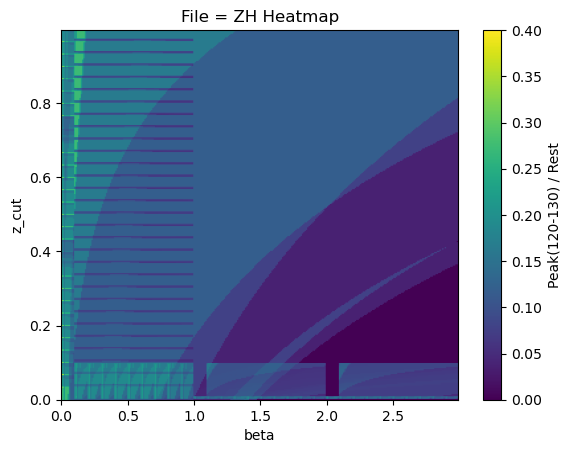

In [7]:
    index = 0
    fig_hm, ax_hm = plt.subplots()
    im = ax_hm.imshow(ratio_matrix,
                      origin='lower',
                      extent=(betas_list[0], betas_list[-1], zcuts_list[0], zcuts_list[-1]),
                      aspect='auto')
    cbar = plt.colorbar(im, ax=ax_hm)
    cbar.set_label("Peak(120-130) / Rest")
    ax_hm.set_xlabel("beta")
    ax_hm.set_ylabel("z_cut")
    ax_hm.set_title(f"File = {prod_mode_matrix[index]} Heatmap")
    plt.savefig(f"{prod_mode_matrix[index]}_heatmap.png", dpi=500)
    plt.show(fig_hm)
    
    plt.close(fig_hm)

    index += 1